### Add libraries & read the image

In [83]:
import cv2
import numpy as np

img = cv2.imread("street.jpeg")
img_height = img.shape[0]
img_width = img.shape[1]
print(img_width, img_height)

872 586


In [84]:
cv2.imshow("img",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

### Converting image to blob
##### What is blob? Images converted to tensors with 4 dimension

In [85]:
img_blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), swapRB=True,crop=False) #params: img resource, scale factorm, blob dimensions(2),BGR to RGB,to crop?
print(img_blob.shape)

(1, 3, 416, 416)


### Read and split labels

In [86]:
label_file = open("labels.txt", 'r')
labels = [word.replace('"','').replace("'",'').replace('[','').replace(']','') for word in str(label_file.readlines()).split(',')]
print(len(labels),labels)
print(labels[0])

80 ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'trafficlight', 'firehydrant', 'stopsign', 'parkingmeter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sportsball', 'kite', 'baseballbat', 'baseballglove', 'skateboard', 'surfboard', 'tennisracket', 'bottle', 'wineglass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hotdog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cellphone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddybear', 'hairdrier', 'toothbrush']
person


### Create color list for bounding boxes

In [87]:
colors = ["0,255,0","0,0,255","255,0,0","0,120,30","0,30,120","50,50,50","50,0,50","50,50,100"]
colors = [np.array(color.split(",")).astype("int") for color in colors]
colors = np.array(colors)
colors = np.tile(colors,(10,1)) #copying color list 10 times to fill the array with same numbers vertically
len(colors)

80

### Read the model and layers

In [88]:
model = cv2.dnn.readNetFromDarknet("model/yolov3.cfg","model/yolov3.weights")
layers = model.getLayerNames()
output_layers = [layers[int(layer)-1] for layer in model.getUnconnectedOutLayers()]
model.setInput(img_blob)
detection_layers = model.forward(output_layers) # reaching out to the values in output layers   

### Testing the image without non-maximum surpression

In [98]:
model.setInput(img_blob)
for detection_layer in detection_layers:
    for object_detection in detection_layer:
        scores = object_detection[5:]
        predicted_id = np.argmax(scores)
        confidence = scores[predicted_id]
        if confidence > 0.20: #draw bounding box if confidence is higher than ..
            label = labels[predicted_id]
            bounding_box = object_detection[0:4] * np.array([img_width,img_height,img_width,img_height])
            (box_center_x, box_center_y,box_width, box_height) = bounding_box.astype("int")

            start_x = int(box_center_x - (box_width/2))
            start_y = int(box_center_y - (box_height/2))

            end_x = start_x + box_width
            end_y = start_y + box_height

            box_color = colors[predicted_id]
            box_color = [int(each) for each in box_color]

            label = "{}: {:.2f}%".format(label,confidence*100)
            print("predicted object: {}".format(label))

            cv2.rectangle(img, (start_x, start_y),(end_x, end_y),box_color,2)
            cv2.putText(img, label, (start_x, start_y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color,1)

predicted object: person: 63.09%
predicted object: car: 86.95%
predicted object: car: 25.98%
predicted object: car: 89.23%
predicted object: person: 73.42%
predicted object: car: 99.16%
predicted object: car: 75.25%
predicted object: car: 41.06%
predicted object: car: 98.68%
predicted object: car: 99.81%
predicted object: car: 21.92%
predicted object: truck: 21.74%
predicted object: truck: 28.45%
predicted object: car: 74.83%
predicted object: truck: 51.46%
predicted object: truck: 30.23%
predicted object: person: 47.08%
predicted object: truck: 27.92%
predicted object: car: 82.27%
predicted object: person: 95.14%
predicted object: person: 33.69%
predicted object: car: 94.88%
predicted object: car: 80.18%
predicted object: car: 96.14%
predicted object: car: 68.34%
predicted object: car: 45.24%
predicted object: car: 69.09%
predicted object: car: 74.37%
predicted object: person: 92.60%
predicted object: person: 55.02%
predicted object: car: 98.81%
predicted object: car: 99.87%
predicted

### Clear the image

In [100]:
img = cv2.imread("street.jpeg")
img_blob = cv2.dnn.blobFromImage(img, 1/255, (416,416), swapRB=True,crop=False) 
model.setInput(img_blob)
detection_layers = model.forward(output_layers)

### Adding non-maximum surpression

In [101]:
ids_list = []
boxes_list = []
confidences_list = []
for detection_layer in detection_layers:
    for object_detection in detection_layer:
        scores = object_detection[5:]
        predicted_id = np.argmax(scores)
        confidence = scores[predicted_id]
        if confidence > 0.20: #draw bounding box if confidence is higher than ..
            label = labels[predicted_id]
            bounding_box = object_detection[0:4] * np.array([img_width,img_height,img_width,img_height])
            (box_center_x, box_center_y,box_width, box_height) = bounding_box.astype("int")

            start_x = int(box_center_x - (box_width/2))
            start_y = int(box_center_y - (box_height/2))

            ## non-maximum surpression step 2 ##
            ids_list.append(predicted_id)
            confidences_list.append(float(confidence))
            boxes_list.append([start_x,start_y,int(box_width),int(box_height)])
            ## non-maximum surpression step 2 ##
            
## non-maximum surpression step 3 ##
max_ids = cv2.dnn.NMSBoxes(boxes_list, confidences_list, 0.5, 0.4)
for max_id in max_ids:
    max_class_id = max_id[0]
    box = boxes_list[max_class_id]
    start_x = box[0]
    start_y = box[1]
    box_width = box[2]
    box_height = box[3]

    predicted_id = ids_list[max_class_id]
    label = labels[predicted_id]
    confidence = confidences_list[max_class_id]
## non-maximum surpression step 3 ##

    end_x = start_x + box_width
    end_y = start_y + box_height

    box_color = colors[predicted_id]
    box_color = [int(each) for each in box_color]

    label = "{}: {:.2f}%".format(label,confidence*100)
    print("predicted object: {}".format(label))

    cv2.rectangle(img, (start_x, start_y),(end_x, end_y),box_color,2)
    cv2.putText(img, label, (start_x, start_y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.5, box_color,1)

predicted object: car: 99.87%
predicted object: car: 99.81%
predicted object: car: 99.66%
predicted object: person: 95.14%
predicted object: car: 83.48%
predicted object: car: 82.27%
predicted object: car: 80.18%
predicted object: bicycle: 65.29%
predicted object: truck: 51.46%


### Show the image with bounding boxes

In [102]:
cv2.imshow("Detection Window",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

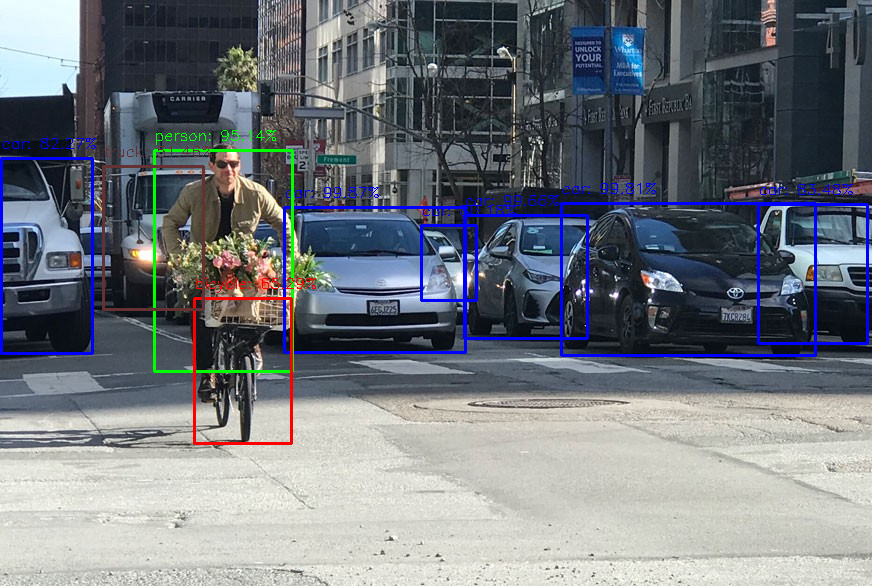

In [105]:
from PIL import Image
import cv2 
from IPython.display import display
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converting BGR to RGB
display(Image.fromarray(img))